<a href="https://colab.research.google.com/github/tadoran/netology_pyda/blob/master/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

### Загрузить файл hr.csv.

In [0]:
# df = pd.read_csv("hr.csv")
df = pd.read_csv("https://raw.githubusercontent.com/tadoran/netology_pyda/master/HR.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Рассчитать основные статистики для переменных (среднее,медиана,мода,мин/макс,сред.отклонение).

In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [0]:
df.mode().T

,0,1
satisfaction_level,0.1,NaN
last_evaluation,0.55,NaN
number_project,4,NaN
average_montly_hours,135,156
time_spend_company,3,NaN
Work_accident,0,NaN
left,0,NaN
promotion_last_5years,0,NaN
sales,sales,NaN
salary,low,NaN


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


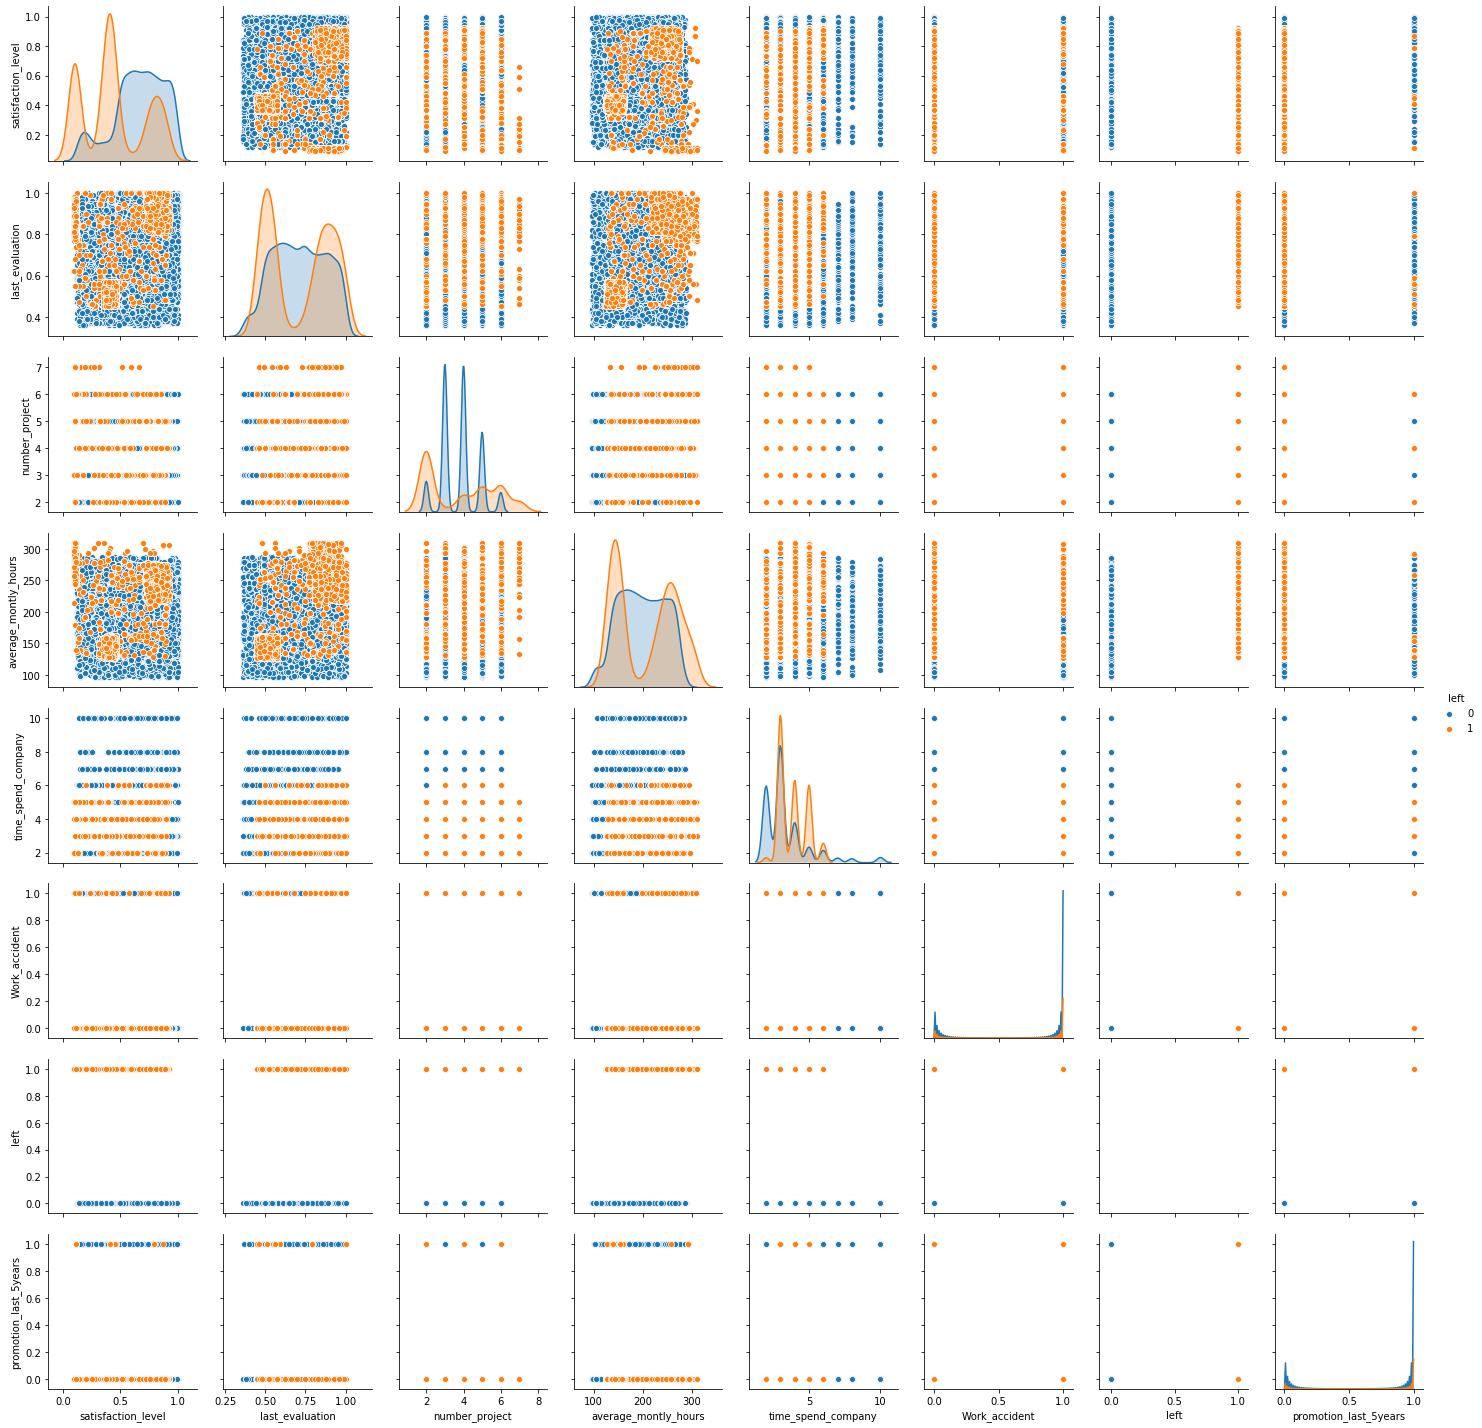

In [0]:
sns.pairplot(df.select_dtypes('number'), hue="left")
plt.show()

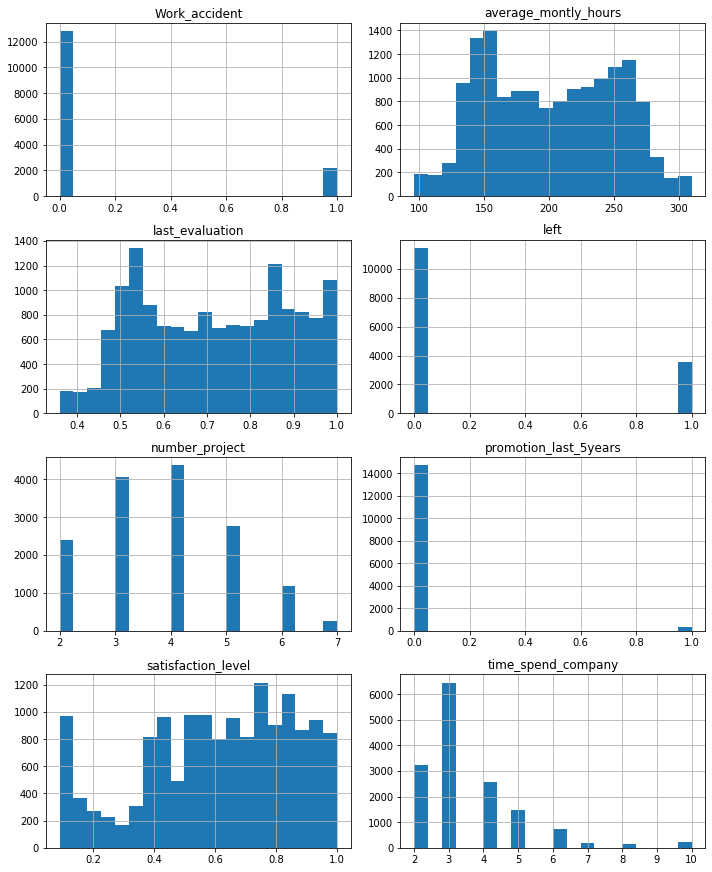

In [0]:
df.select_dtypes('number').hist(layout=(5,2), figsize=(10,15), bins=20)
plt.tight_layout()

### Рассчитать и визуализировать корреляционную матрицу для переменных.

In [0]:
df.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


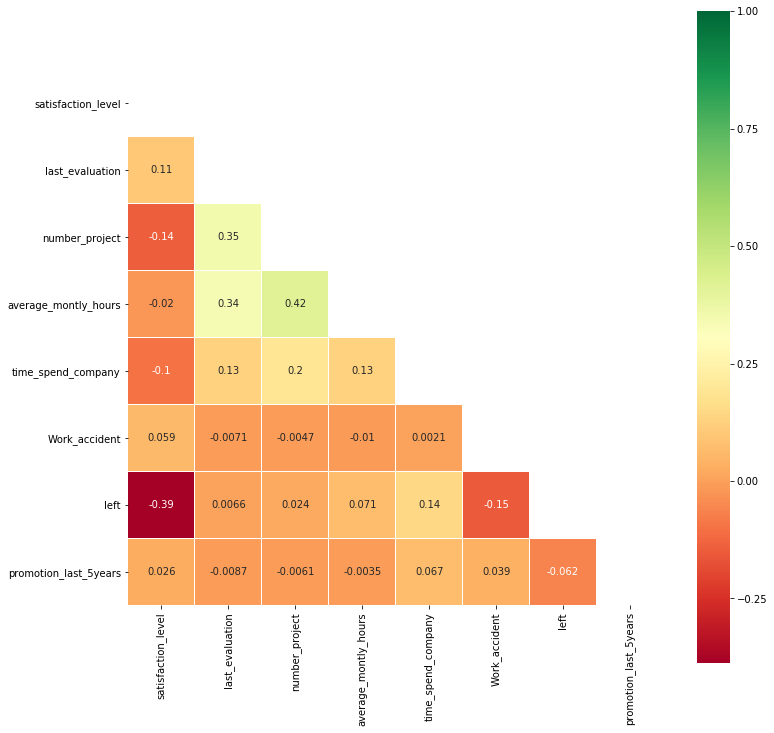

In [0]:
plt.figure(figsize = (12,12))

corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=corr, mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2, square=True)
plt.show()

In [0]:
sorted_corr = corr                              \
                .mask(mask)                     \
                .mask(abs(corr)<=0.2)           \
                .unstack()                      \
                .sort_values()                  \
                .sort_values(ascending = False) \
                .dropna()
print("Самые сильные корреляции")
for key, value in sorted_corr.items():
    param1 = "|" + key[0].replace('\n',' ') + "|" 
    param2 = "|" + key[1].replace('\n',' ') + "|" 
    print(f"{param1} to {param2}: {value:1.3f}")
print() 

Самые сильные корреляции
|number_project| to |average_montly_hours|: 0.417
|last_evaluation| to |number_project|: 0.349
|last_evaluation| to |average_montly_hours|: 0.340
|satisfaction_level| to |left|: -0.388



### Визуализировать несколько взаимосвязей между переменными.

In [0]:
# Часть переменных распределены непрерывно, группируем для удобства анализа
bins = 5
df["evaluation_group"]   = pd.cut(x=df.last_evaluation,      bins=bins,labels=range(bins))
df["hours_group"]        = pd.cut(x=df.average_montly_hours, bins=bins,labels=range(bins))
df["satisfaction_group"] = pd.cut(x=df.satisfaction_level  , bins=bins,labels=range(bins))

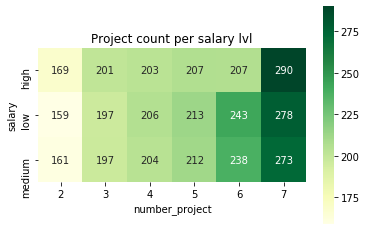

In [0]:
# Взаимосвязь зарплаты и количества проектов у сотрудника
salary_projects_avg_mon = pd.pivot_table(
                                df, 
                                index="salary",columns="number_project", 
                                values= "average_montly_hours"
                            )
sns.heatmap(salary_projects_avg_mon, square=True, annot=True, fmt="1.0f", cmap="YlGn")
plt.title("Project count per salary lvl")
plt.show()

Загрузка сотрудников, ведущих несколько проектов тем выше, чем большее количество проектов за ними числится. (Логично :-) )

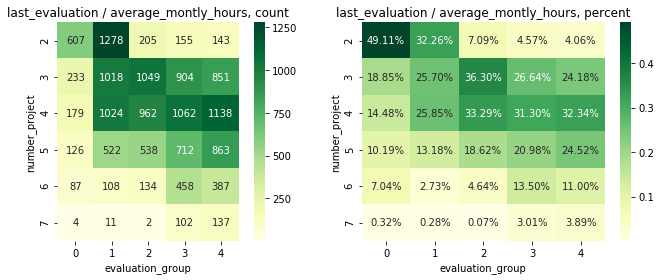

In [0]:
# Взаимосвязь между количеством проектов и последней оценкой у сотрудников
evaluation_projects = (
                        pd.pivot_table(
                                df, fill_value=0,
                                columns=["evaluation_group"], index="number_project", 
                                values="average_montly_hours", aggfunc="count"
                            )
                        )
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax = axes.flatten()

# Кол-во сотрудников и % внутри группы оценок
sns.heatmap(evaluation_projects, square=True, annot=True, fmt="1.0f", cmap="YlGn", ax=ax[0])
sns.heatmap(evaluation_projects.apply(lambda x:x/sum(x), axis=0), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[1])
ax[0].set_title("last_evaluation / average_montly_hours, count")
ax[1].set_title("last_evaluation / average_montly_hours, percent")
plt.tight_layout()
plt.show()


Сотрудники с более высоким баллом по аттестации, как правило, участвуют в большем количестве проектов.

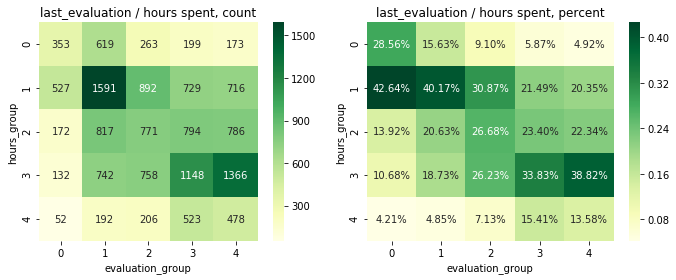

In [0]:
# Взаимосвязь между загрузкой и последней оценкой у сотрудников 
evaluation_hours = (
                    pd.pivot_table(
                            df, fill_value=0,
                            columns=["evaluation_group"], index="hours_group", 
                            values="number_project", aggfunc="count"
                        )
                    )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax = axes.flatten()

# Кол-во сотрудников и % внутри группы оценок
sns.heatmap(evaluation_hours, square=True, annot=True, fmt="1.0f", cmap="YlGn", ax=ax[0])
sns.heatmap(evaluation_hours.apply(lambda x:x/sum(x), axis=0), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[1])
ax[0].set_title("last_evaluation / hours spent, count")
ax[1].set_title("last_evaluation / hours spent, percent")
plt.tight_layout()
plt.show()

Сотрудники с более высоким баллом по аттестации, как правило, имеют большую нагрузку. Переменные количества проектов и затраченных часов сильно связаны, поэтому удивления это не вызывает.

### С использованием t-test статистики проверить взаимосвязи между несколькими переменными.

H0 - различие в оценках по тесту у уволившихся сотрудников и всех сотрудников отсутствует.

In [0]:
ttest = stats.ttest_ind(df["last_evaluation"], df[df["left"] == 1]["last_evaluation"])
print(ttest)
print(f"{ttest.pvalue:0.5f}")

Ttest_indResult(statistic=-0.6116021924432762, pvalue=0.540808475065452)
0.54081


P = 0.54, следовательно нулевая гипотеза не отвергается.

H0 - Уровень удовлетворенности у уволившихся и работающих сотрудников не отличается.

In [0]:
ttest = stats.ttest_ind(df[df["left"] == 0]["satisfaction_level"], df[df["left"] == 1]["satisfaction_level"])
print(ttest)
print(f"{ttest.pvalue:0.5f}")

Ttest_indResult(statistic=51.61280155890104, pvalue=0.0)
0.00000


P = 0.00, нулевая гипотеза отвергается.

H0 - среднее количество отработанных часов не отличается в группах уволившихся и работающих сотрудников.

In [0]:
ttest = stats.ttest_ind(df[df["left"] == 0]["average_montly_hours"], df[df["left"] == 1]["average_montly_hours"])
print(ttest)
print(f"{ttest.pvalue:0.5f}")

Ttest_indResult(statistic=-8.752254731850009, pvalue=2.3113035567540143e-18)
0.00000


Р = 0.00, нулевая гипотеза отвергается.

### Рассчитать сколько работников работает в каждом департаменте.

In [0]:
pd.pivot_table(
                df, 
                columns=["left", "salary"], index="sales", 
                values= "average_montly_hours", aggfunc="count"
                )

left           0                 1            
salary      high   low medium high  low medium
sales                                         
IT            79   437    438    4  172     97
RandD         47   309    310    4   55     62
accounting    69   259    235    5   99    100
hr            39   243    242    6   92    117
management   224   121    194    1   59     31
marketing     71   276    308    9  126     68
product_mng   62   346    296    6  105     87
sales        255  1402   1469   14  697    303
support      133   757    784    8  389    158
technical    176   994    853   25  378    294

In [0]:
# Все сотрудники
employees_count_all = df.groupby("sales").count().iloc[:,0]
employees_count_all

sales
IT             1227
RandD           787
accounting      767
hr              739
management      630
marketing       858
product_mng     902
sales          4140
support        2229
technical      2720
Name: satisfaction_level, dtype: int64

In [0]:
# Только работающие сотрудники
employees_count_cur = df[df["left"] == 0].groupby("sales").count().iloc[:,0]
employees_count_cur

sales
IT              954
RandD           666
accounting      563
hr              524
management      539
marketing       655
product_mng     704
sales          3126
support        1674
technical      2023
Name: satisfaction_level, dtype: int64

In [0]:
# Только уволившиеся сотрудники
employees_count_left = df[df["left"] == 1].groupby("sales").count().iloc[:,0]
employees_count_left

sales
IT              273
RandD           121
accounting      204
hr              215
management       91
marketing       203
product_mng     198
sales          1014
support         555
technical       697
Name: satisfaction_level, dtype: int64

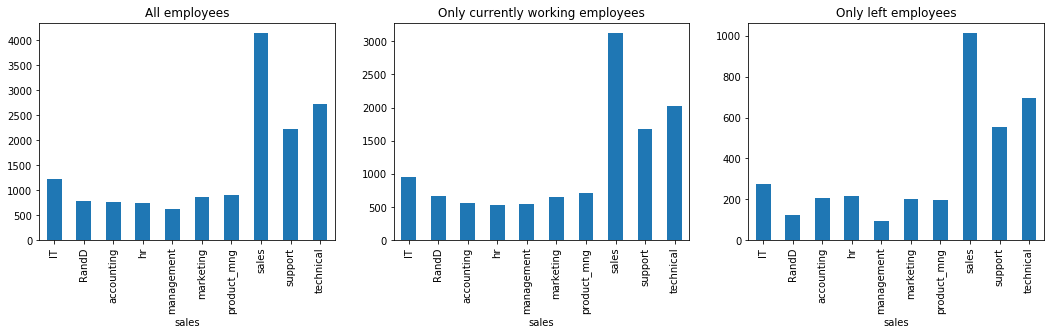

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax = axes.flatten()

# Все
employees_count_all.plot(kind="bar", ax=ax[0])
ax[0].set_title("All employees")

# Работающие
employees_count_cur.plot(kind="bar", ax=ax[1])
ax[1].set_title("Only currently working employees")

# Уволившиеся
employees_count_left.plot(kind="bar", ax=ax[2])
ax[2].set_title("Only left employees")

plt.show()

### Показать распределение сотрудников по зарплатам.


In [0]:
# Все сотрудники
employees_all_salary = df.groupby("salary").count().loc[["low","medium","high"]]["left"]
# Только работающие сотрудники
employees_cur_salary = df[df["left"] == 0].groupby("salary").count().loc[["low","medium","high"]]["left"]
# Только уволившиеся сотрудники
employees_left_salary = df[df["left"] == 1].groupby("salary").count().loc[["low","medium","high"]]["left"]

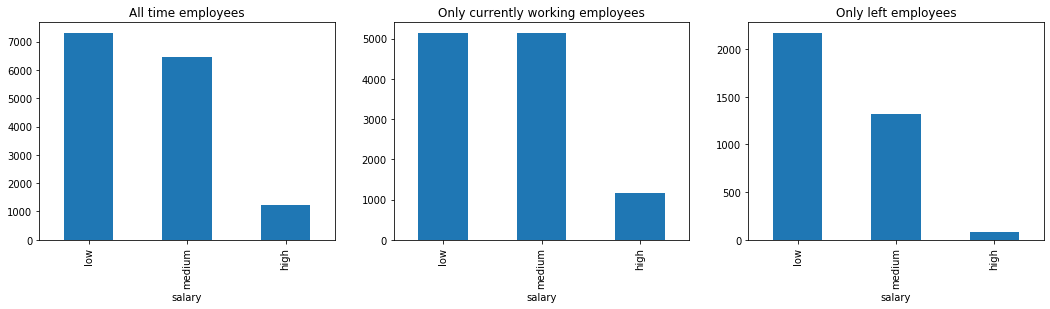

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
ax = axes.flatten()

# Все
employees_all_salary.plot(kind="bar", ax=ax[0])
ax[0].set_title("All time employees")

# Работающие
employees_cur_salary.plot(kind="bar", ax=ax[1])
ax[1].set_title("Only currently working employees")

# Уволившиеся
employees_left_salary.plot(kind="bar", ax=ax[2])
ax[2].set_title("Only left employees")

plt.show()

Интересно, что работники с высокими зарплатами увольняются реже, в то время как сотрудники с низкой зарплатой в меньшей степени заинтересованы в сохранении своего места.

### Показать распределение сотрудников по зарплатам совместно с департаментами.

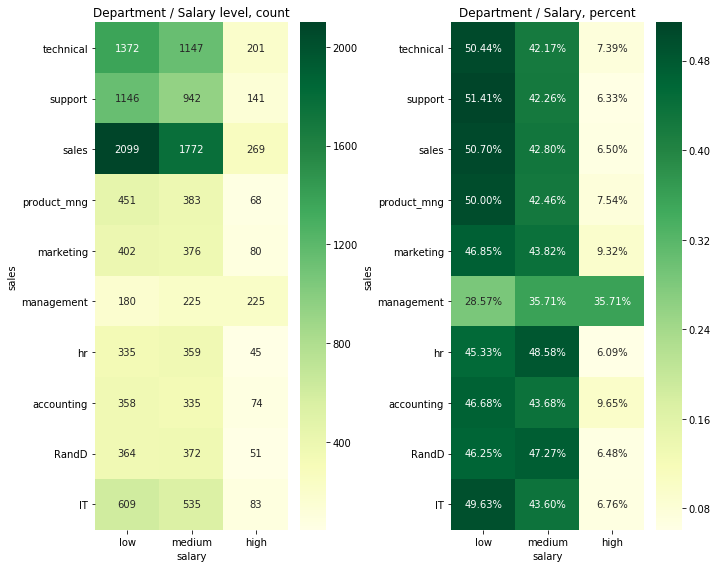

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
ax = axes.flatten()

sorted_pivot = (pd.pivot_table(
                                df, 
                                columns="salary", 
                                index="sales", 
                                values= "average_montly_hours", 
                                aggfunc="count"
                            )
                            .sort_values(by="sales", ascending=False)
                            .loc[:,["low","medium","high"]]
               )

# Кол-во сотрудников, % от группы
sns.heatmap(sorted_pivot, annot=True, fmt="1.0f", ax=ax[0], cmap="YlGn")
sns.heatmap(sorted_pivot.apply(lambda x:x/sum(x), axis=1), annot=True, fmt="0.2%", ax=ax[1], cmap="YlGn")
ax[0].set_title("Department / Salary level, count")
ax[1].set_title("Department / Salary, percent")
plt.tight_layout()


Самое большое количество сотрудников - в продажах.  
Самые высокие зарплаты - в группе менеджмента.

### Сколько сотрудников покинули компанию.

In [0]:
df[df["left"] == 1]["left"].count()

3571

### Проверить несколько гипотез для данных, чтобы понять почему сотрудники покидают компанию.

#### Сотрудники с низким уровнем удовлетворенности увольняются чаще

In [0]:
satisfaction_salary = (
                        pd.pivot_table(
                                df, 
                                columns=["left"], 
                                index="satisfaction_group", 
                                values="time_spend_company",
                                aggfunc="count",
                                fill_value=0
                            )
                        )
satisfaction_salary

left,0,1
satisfaction_group,,
0,892,941
1,733,1522
2,3097,149
3,3422,461
4,3284,498


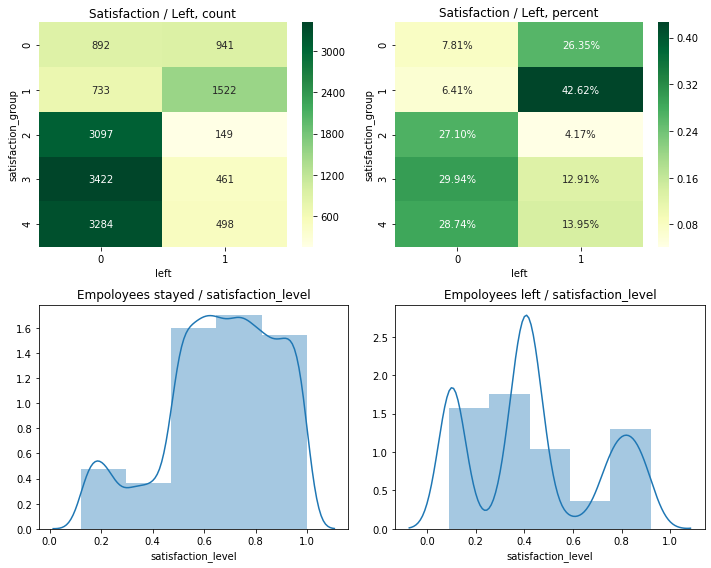

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = axes.flatten()

# Кол-во и % от группы
sns.heatmap(satisfaction_salary, annot=True, fmt="1.0f", ax=ax[0], cmap="YlGn")
sns.heatmap(satisfaction_salary.apply(lambda x:x/sum(x), axis=0), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[1])
ax[0].set_title("Satisfaction / Left, count")
ax[1].set_title("Satisfaction / Left, percent")

# Распределение - работающие и уволившиеся
sns.distplot( a=df["satisfaction_level"][df["left"] == False], hist=True, kde=True, ax=ax[2], bins=5)
sns.distplot( a=df["satisfaction_level"][df["left"] == True], hist=True, kde=True, ax=ax[3], bins=5)
ax[2].set_title("Empoloyees stayed / satisfaction_level")
ax[3].set_title("Empoloyees left / satisfaction_level")

plt.tight_layout()

Визуально видно, что в группе уволившихся сотрудников уровень удовлетворенности ниже.  
Проверим с использованием статистики.

In [0]:
ttest = stats.ttest_ind(df["satisfaction_level"][df["left"] == False], df["satisfaction_level"][df["left"] == True])
print(ttest)
print(f"P = {ttest.pvalue:0.5f}")

Ttest_indResult(statistic=51.61280155890104, pvalue=0.0)
P = 0.00000


T-value = 51, P=0.0, следовательно нулевая гипотеза о различии в выборках должна быть принята.  
Но распределние не слишком похоже на нормальное, применим распределение Манна-Уитни.

In [0]:
mannwhitneyu = stats.mannwhitneyu(df["satisfaction_level"][df["left"] == False], df["satisfaction_level"][df["left"] == True])
print(mannwhitneyu)
print(f"P = {mannwhitneyu.pvalue:0.5f}")

MannwhitneyuResult(statistic=10286473.0, pvalue=0.0)
P = 0.00000


P = 0.0, гипотеза принимается.

#### Сотрудники с низкой или, наоборот, высокой оценкой (evaluation) увольняются чаще 

In [0]:
evaluation_left = (
                    pd.pivot_table(
                            df, fill_value=0, 
                            columns=["left"], index="evaluation_group", 
                            values="satisfaction_group", aggfunc="count"
                        )
                    )
evaluation_left

left,0,1
evaluation_group,,
0,760,476
1,2820,1141
2,2814,76
3,2617,776
4,2417,1102


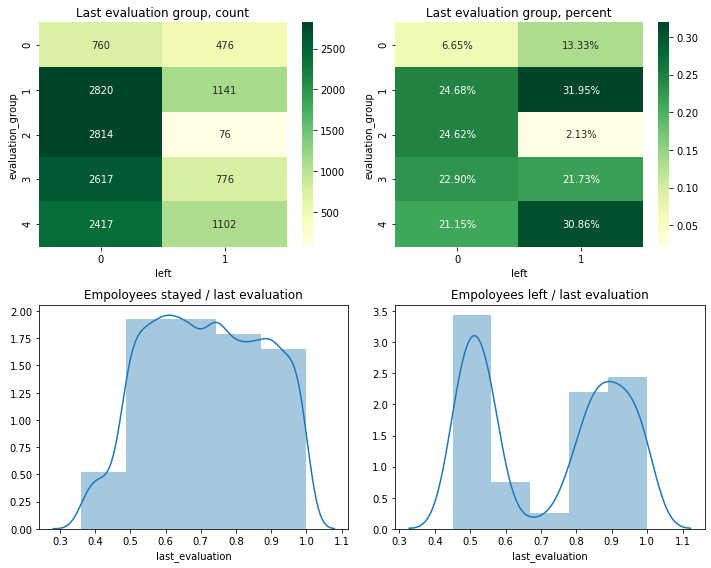

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = axes.flatten()

# Кол-во и % от группы
sns.heatmap(evaluation_left, annot=True, fmt="1.0f", ax=ax[0], cmap="YlGn")
sns.heatmap(evaluation_left.apply(lambda x:x/sum(x), axis=0), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[1])
ax[0].set_title("Last evaluation group, count")
ax[1].set_title("Last evaluation group, percent")

# Распределение - работающие и уволившиеся 
sns.distplot( a=df["last_evaluation"][df["left"] == False], hist=True, kde=True, ax=ax[2], bins=5)
sns.distplot( a=df["last_evaluation"][df["left"] == True], hist=True, kde=True, ax=ax[3], bins=5)
ax[2].set_title("Empoloyees stayed / last evaluation")
ax[3].set_title("Empoloyees left / last evaluation")

plt.tight_layout()

На графиках заметно, что распределение баллов у ныне работающих сотрудников  отличается от распределения у уволившихся (уволенных).   
Вероятно, что сотрудники с низким баллом не справлялись с нагрузкой, что служило причиной увольнения.  
Уволившиеся с высоким баллом, вероятно, "переросли" свою должность, и уходили с расчетом на повышение.

In [0]:
ttest = stats.ttest_ind(df["last_evaluation"][df["left"] == 0], df["last_evaluation"][df["left"] == 1])
print(ttest)
print(f"P = {ttest.pvalue:0.5f}")

Ttest_indResult(statistic=-0.8042416167796329, pvalue=0.4212701963735056)
P = 0.42127


T-value = 0.8, P=0.4, следовательно нулевая гипотеза не может быть принята.  
Применим распределение Манна-Уитни.

In [0]:
mannwhitneyu = stats.mannwhitneyu(df["last_evaluation"][df["left"] == 0], df["last_evaluation"][df["left"] == 1])
print(mannwhitneyu)
print(f"P = {mannwhitneyu.pvalue:0.5f}")

MannwhitneyuResult(statistic=20337201.0, pvalue=0.3825174633239001)
P = 0.38252


P = 0.38, следовательно, гипотеза отвергается.

#### Уволившихся сотрудников реже повышали в должности

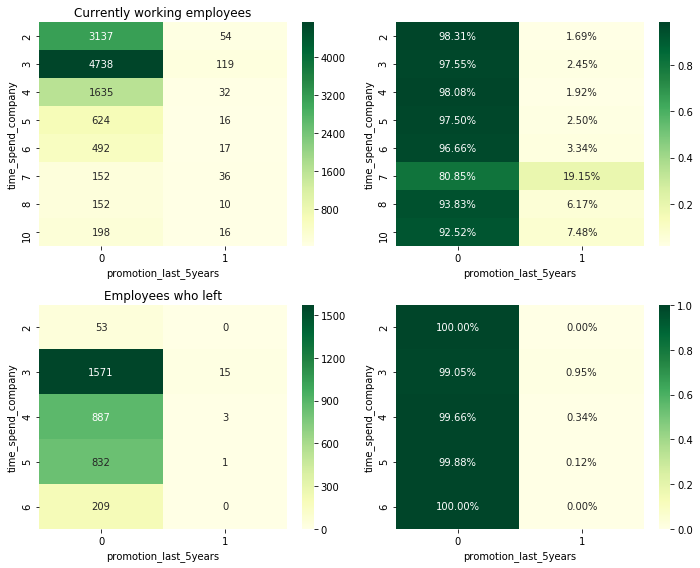

In [0]:
# Кол-во повышенных и не повышенных сотрудников среди работающих
promotion_years_cur = (
                    pd.pivot_table(
                            df[df["left"] == 0], fill_value=0, 
                            columns="promotion_last_5years", index="time_spend_company", 
                            values="satisfaction_group", aggfunc="count"
                        )
                    )

# Кол-во повышенных и не повышенных сотрудников среди уволившихся
promotion_years_left = (
                    pd.pivot_table(
                            df[df["left"] == 1], fill_value=0, 
                            columns="promotion_last_5years", index="time_spend_company", 
                            values="satisfaction_group", aggfunc="count"
                        )
                    )

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax = axes.flatten()

# Работающие
sns.heatmap(promotion_years_cur, annot=True, fmt="1.0f", ax=ax[0], cmap="YlGn")
sns.heatmap(promotion_years_cur.apply(lambda x:x/sum(x), axis=1), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[1])
ax[0].set_title("Currently working employees")

# Уволившиеся
sns.heatmap(promotion_years_left, annot=True, fmt="1.0f", ax=ax[2], cmap="YlGn")
sns.heatmap(promotion_years_left.apply(lambda x:x/sum(x), axis=1), annot=True, fmt="0.2%", cmap="YlGn", ax=ax[3])
ax[2].set_title("Employees who left")

plt.tight_layout()
plt.show()

Несмотря на то, что общее количество повышенных в должности сотрудников не слишком высоко, видна разница в группе работающих и уволившихся.  
При одинаковом количестве проведенных в компании лет, в группе уволившихся количество повышенных в дожности сотрудников сильно ниже.  
С другой стороны, нет уволившихся сотрудников, проработавших более шести лет, а, наибольшее количество  "повышенных" сотрудников - в группе проработавших более 6 лет.  
Следовательно, есть вероятность, что при отказе от увольнения, шанс таки получить повышение у этих сотрудников бы рос. 

In [0]:
ttest = stats.ttest_ind(df[df["left"] == 0]["promotion_last_5years"], df[df["left"] == 1]["promotion_last_5years"])
print(ttest)
print(f"P = {ttest.pvalue:0.5f}")

Ttest_indResult(statistic=7.581195349367637, pvalue=3.624047224146943e-14)
P = 0.00000


T-value = 7.5, P=0.0, следовательно  гипотеза принимается принята.  
Применим распределение Манна-Уитни.

In [0]:
mannwhitneyu = stats.mannwhitneyu(df[df["left"] == 0]["promotion_last_5years"], df[df["left"] == 1]["promotion_last_5years"])
print(mannwhitneyu)
print(f"P = {mannwhitneyu.pvalue:0.5f}")

MannwhitneyuResult(statistic=19977610.0, pvalue=1.9103960097818644e-14)
P = 0.00000


P = 0.0, следовательно, гипотеза принимается.